### Paquette Profit Function (Total Absolute Gain)

$$
\Pi:= \sum_{\textit{weeks with output } 1} 1 \cdot (\text{Close} - \text{Open}) + \sum_{\textit{weeks with output } -1} -1 \cdot (\text{Close} - \text{Open}) = \sum_{\textit{all weeks}} \text{Output}_{\text{week}} \cdot (\text{Close} - \text{Open})
$$

### Gian Gain Function (Total Return)

The total return over all weeks, $\Gamma$, can be expressed as:

$$
\Gamma = \prod_{t=1}^{T} \left(1 + \text{PortfolioReturn}_t\right) - 1
$$

Where $\text{PortfolioReturn}_t$ for each week $t$ is:

$$
\text{Portfolio\_Return}_t = 
\begin{cases} 
\frac{\text{Next\_week\_pct\_change}_t}{100} & \text{if } \text{Output}_t = 1 \\
-\frac{\text{Next\_week\_pct\_change}_t}{100} & \text{if } \text{Output}_t = -1 \\
0 & \text{if } \text{Output}_t = 0
\end{cases}
$$

Substituting this back into the total return calculation, we get:

$$
\Gamma = \prod_{t=1}^{T} \left(1 + \frac{\text{Next\_week\_pct\_change}_t}{100} \cdot \text{Output}_t \right) - 1 = 
$$


In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utilities import (
calculate_rsi, calculate_cci, calculate_emadn, 
calculate_cpc, grid_search_hurst, calculate_indicators, 
categorize_change, calculate_returns, calculate_max_drawdown_duration, 
calculate_yearly_returns, plot_return)

import sys
#sys.path.append(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\anfis_libraries')
sys.path.append(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\anfis_gian')

import anfis
import membership 
import experimental
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nolds

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
msft = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Microsoft_weekly_ok.csv', index_col=False, parse_dates=['Date'])
#amzn = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Amazon_weekly_ok.csv')
amzn = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Amazon_weekly_ok.csv', index_col=False, parse_dates=['Date'])
ibm = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\IBM_weekly_ok.csv', index_col=False, parse_dates=['Date'])
cac = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Cac_weekly_ok.csv', index_col=False, parse_dates=['Date'])
sp500 = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Sp500_weekly_ok.csv', index_col=False, parse_dates=['Date'])
nasdaq = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Nasdaq_weekly_ok.csv', index_col=False, parse_dates=['Date'])

In [7]:
'''
# Function to add indicators
def calculate_rsi(df, rsi_period=14):
    # Calculate RSI (Relative Strength Index)
    price_change = df['Close'].diff()
    upward_changes = price_change.clip(lower=0)
    downward_changes = -price_change.clip(upper=0)
    average_upward_changes = upward_changes.rolling(window=rsi_period).mean()
    average_downward_changes = downward_changes.rolling(window=rsi_period).mean()
    relative_strength = average_upward_changes / average_downward_changes
    df['RSI'] = 100 - (100 / (1 + relative_strength))

    return df

def calculate_cci(df, cci_period=20):
    # Calculate CCI (Commodity Channel Index)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma_typical_price = typical_price.rolling(window=cci_period).mean()
    mean_deviation = (typical_price - sma_typical_price).abs().rolling(window=cci_period).mean()
    df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)

    return df

def calculate_emadn(df, ema_short_period=10, ema_long_period=40):
    ema_short_column = f'EMA{ema_short_period}'
    ema_long_column = f'EMA{ema_long_period}'
    ema_difference_column = f'EMA{ema_short_period}_EMA{ema_long_period}_Difference_Normalized'

    # Calculate short and long period exponential moving averages
    df[ema_short_column] = df['Close'].ewm(span=ema_short_period, adjust=False).mean()
    df[ema_long_column] = df['Close'].ewm(span=ema_long_period, adjust=False).mean()

    # Calculate the difference of exponential moving averages
    df[ema_difference_column] = (df[ema_short_column] - df[ema_long_column])/df[ema_long_column]

    return df

def calculate_cpc(df, cpc_window=4):
    # Calculate CPC (Current Price Change)
    rolling_mean_close = df['Close'].rolling(cpc_window).mean()
    df['CPC'] = 1 / (1 + np.exp(-(df['Close'] - rolling_mean_close.shift(1)) / rolling_mean_close.shift(1) * 100))

    return df

def calculate_indicators(df, rsi_period=14, cci_period=20, ema_short_period=10, ema_long_period=40, cpc_window=4):
    calculate_rsi(df, rsi_period)
    calculate_cci(df, cci_period)
    calculate_emadn(df, ema_short_period, ema_long_period)
    calculate_cpc(df, cpc_window)
    
    return df

# Define a function to categorize the change as +1, 0, or -1
# Set a threshold for what we consider to be a flat week, e.g. 0.5% price change
def categorize_change(weekly_return, flat_threshold=0.5):
    if weekly_return > flat_threshold:
        return 1  # Bullish
    elif weekly_return < -flat_threshold:
        return -1  # Bearish
    else:
        return 0  # Flat

def calculate_returns(df, prediction_column):
    # Calculate the portfolio return based on the prediction
    df['Shifted_Prediction'] = df[prediction_column].shift(1)
    df['Portfolio_Return'] = df.apply(
        lambda row: (row['Current_week_pct_change'] / 100) * row['Shifted_Prediction'], axis=1
    )
    df.drop(columns=['Shifted_Prediction'], inplace=True)
    
    # Fill NaNs, which would be in the first row after shifting
    df['Portfolio_Return'].fillna(0, inplace=True)

    # Calculate cumulative returns
    df['Cumulative_Return'] = (1 + df['Portfolio_Return']).cumprod() - 1

    # Calculate 'high water mark', i.e. highest cumulative return so far, to visualize drawdowns
    df['High_Water_Mark'] = df['Cumulative_Return'].cummax()

    total_return=df['Cumulative_Return'].iloc[-1]

    print(f'Total return over the dataset: {round(total_return*100, 1)} %')

    return df

def calculate_max_drawdown_duration(df):
    uwater = df['Cumulative_Return'] < df['High_Water_Mark']
    runs = (~uwater).cumsum()[uwater]
    drawdown_durations = runs.value_counts(sort=True)
    return drawdown_durations.iloc[0] if not drawdown_durations.empty else 0

def calculate_yearly_returns(df):
    print('─' * 40)
    df['Year'] = df['Date'].dt.year
    years = df['Year'].unique()
    for year in years:
        year_df=calculate_returns(df[df['Year']==year], 'Prediction')
        max_yearly_drawdown=calculate_max_drawdown_duration(year_df)
        yearly_cumulative_return=year_df['Cumulative_Return'].iloc[-1]

        print(f'Return in year {year}: {round(yearly_cumulative_return * 100, 1)} %')
        print(f'Maximum drawdown during year {year}: {max_yearly_drawdown} weeks')
        print('─' * 40)

def plot_return(df, name, train_test_split=None, save_figure=False):
    plt.style.use('default')

    plt.rcParams['font.sans-serif'] = 'Arial'
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
    if train_test_split!=None:
        # Add line for training/validation split
        split_idx = int(len(df) * train_test_split)
        ax.axvline(x=df['Date'].iloc[split_idx], color='darkgrey', linestyle='--', label='Train/Validation Split')
        
    # Plot cumulative returns and high water mark
    ax.plot(df['Date'], df['Cumulative_Return'], label='Cumulative Return', color='darkgreen', linewidth=1)
    ax.plot(df['Date'], df['High_Water_Mark'], label='Drawdown line', color='darkred', linewidth=1, alpha=0.9)
    ax2=ax.twinx()
    ax2.plot(df['Date'], df['Close'], label='Close price', color='#3498db', alpha=0.5, linewidth=1)
    
    ax.set_title(f'{name} Long-Short Equity Strategy Performance')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return', color='darkgreen')
    ax.tick_params(axis='y', labelcolor='darkgreen')
    ax2.set_ylabel('Adjusted Close price (USD)', color='#3498db') 
    ax2.tick_params(axis='y', labelcolor='#3498db')
    
    fig.legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)
    if save_figure:
        plt.savefig(f'{name}_gianfis_return.png', transparent=True, dpi=300)
    plt.show()
'''

In [3]:
hurst_results_df=grid_search_hurst(amzn)
hurst_results_df

,Indicator,Best Period,Hurst Exponent,Best Short Period,Best Long Period
0,CCI,36,0.90,<NA>,<NA>
1,EMADN,<NA>,0.92,24,52
2,CPC,39,0.99,<NA>,<NA>
3,RSI,38,0.96,<NA>,<NA>


In [9]:
dfs = [amzn, cac, ibm, msft, nasdaq, sp500]

for df in dfs:
    # Verify dates are datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Verify dates are sorted
    df.sort_values('Date', inplace=True)
    
    # Use .loc to filter and access values correctly
    rsi_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'RSI', 'Best Period'].values[0]
    cci_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'CCI', 'Best Period'].values[0]
    ema_short_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'EMADN', 'Best Short Period'].values[0]
    ema_long_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'EMADN', 'Best Long Period'].values[0]
    cpc_window = hurst_results_df.loc[hurst_results_df['Indicator'] == 'CPC', 'Best Period'].values[0]
        
    # Now use these values to calculate the indicators
    calculate_indicators(df, 
                         rsi_period=rsi_period,
                         cci_period=cci_period, 
                         ema_short_period=ema_short_period, 
                         ema_long_period=ema_long_period, 
                         cpc_window=cpc_window)

# Drop rows with na, depending on parameters chosen for indicators
amzn.dropna(inplace=True)
amzn.reset_index(inplace=True, drop=True)

amzn.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'RSI', 'CCI',
       'EMA24_EMA52_Difference_Normalized', 'CPC'],
      dtype='object')

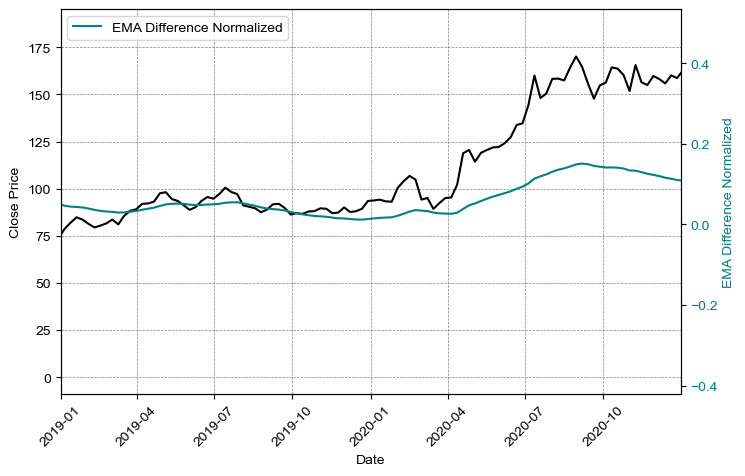

In [11]:
plt.style.use('default')

plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['EMA24_EMA52_Difference_Normalized'], color='#008080', label='EMA Difference Normalized')
ax2.set_ylabel('EMA Difference Normalized', color='#008080')
ax2.tick_params(axis='y', labelcolor='#008080')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('EMADN.png', transparent=True)
plt.show()

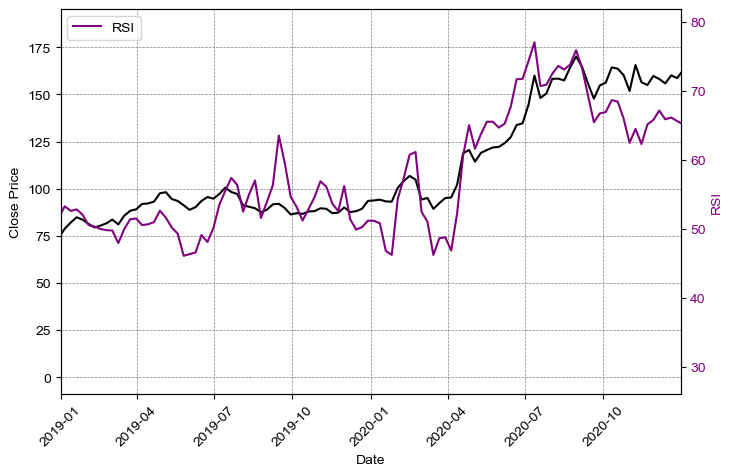

In [12]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['RSI'], color='#800080', label='RSI')
ax2.set_ylabel('RSI', color='#800080')
ax2.tick_params(axis='y', labelcolor='#800080')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('RSI.png', transparent=True)
plt.show()

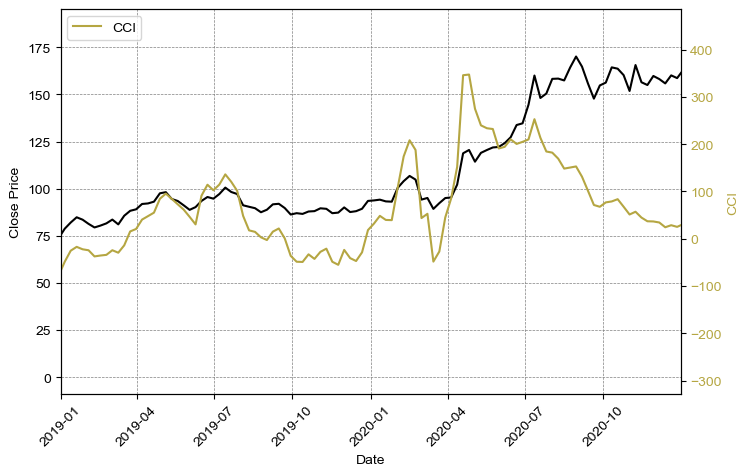

In [13]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CCI'], color='#B5A642', label='CCI')
ax2.set_ylabel('CCI', color='#B5A642')
ax2.tick_params(axis='y', labelcolor='#B5A642')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('CCI.png', transparent=True)

plt.show()

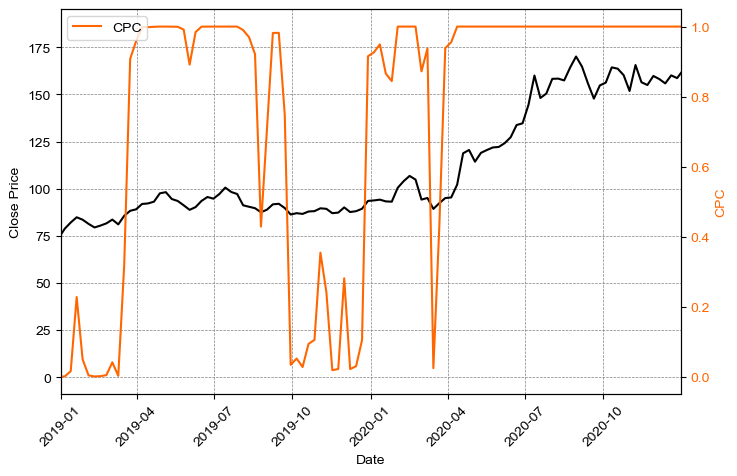

In [14]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CPC'], color='#FF6600', label='CPC')
ax2.set_ylabel('CPC', color='#FF6600')
ax2.tick_params(axis='y', labelcolor='#FF6600')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('CPC.png', transparent=True)

plt.show()

Target variable is Market Behavior:
- Bullish (upcoming week’s close is higher than the current week’s close): Assign +1.  
- Bearish (upcoming week’s close is lower than the current week’s close): Assign -1.  
- Flat (upcoming week’s close is approximately, according to a threshold, equal to the current week’s close): Assign 0.

In [32]:
# Calculate the percentage change in closing price from one week to the next
amzn['Current_week_pct_change'] = 100 * amzn['Close'].pct_change(periods=1)
amzn['Next_week_pct_change'] = 100 * amzn['Close'].pct_change(periods=1).shift(-1)

# Apply the function to the percentage change column to create the target variable
amzn['Next_week_market_behavior'] = amzn['Next_week_pct_change'].apply(categorize_change)

# Drop the first and last rows as they contain NaN values in the 'Current_week_pct_change' and 'Next_week_pct_change' columns
amzn = amzn.dropna(subset=['Current_week_pct_change', 'Next_week_pct_change'])

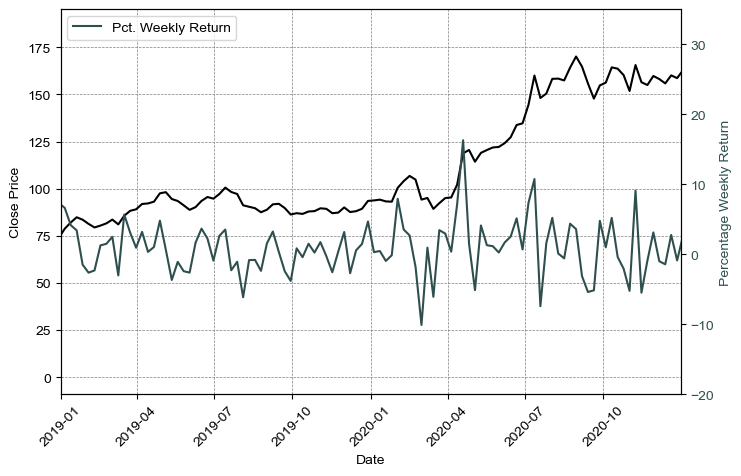

In [33]:
plt.style.use('default')

plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['Current_week_pct_change'], color='#2F4F4F', label='Pct. Weekly Return')
ax2.set_ylabel('Percentage Weekly Return', color='#2F4F4F')
ax2.set_ylim([-20, 35])
ax2.tick_params(axis='y', labelcolor='#2F4F4F')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('PercentageReturn.png', transparent=True)

plt.show()

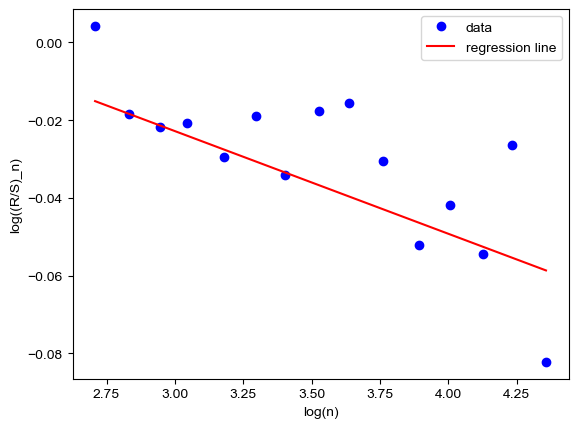

Hurst exponent (R/S): 0.47


In [34]:
H_rs=nolds.hurst_rs(data=amzn['Current_week_pct_change'], debug_plot=True)
print("Hurst exponent (R/S):", round(H_rs,2))

In [17]:
# Define your feature columns
feature_columns = ['EMA23_EMA53_Difference_Normalized', 'RSI', 'CCI', 'CPC', 'Current_week_pct_change']

# Now let's prepare the features
features = amzn[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)
print(features)

# Prepare the target to fit the labeling {0,1,2}
target = amzn['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

[[0.74069405 0.84490783 0.54684515 1.         0.38585863]
 [0.74819725 0.8355714  0.52063335 1.         0.32066245]
 [0.75238346 0.81584976 0.52806047 1.         0.29443595]
 ...
 [0.51917573 0.81533538 0.71709316 1.         0.31243038]
 [0.52271753 0.75034926 0.5629503  1.         0.27169465]
 [0.52723301 0.74831137 0.52817441 1.         0.32824845]]


In [18]:
# Define the membership functions for RSI and store in invars:
invars = [
    ('RSI', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('CCI', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('CPC', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('MADN', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('RETURN',[
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ])
]

model = anfis.AnfisNetClassifier(invardefs=invars, num_classes=3)

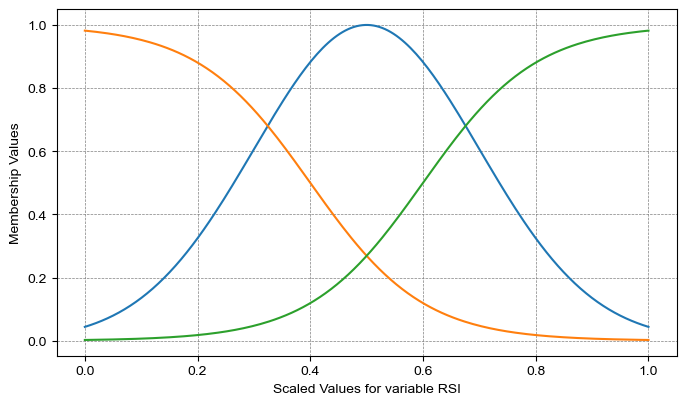

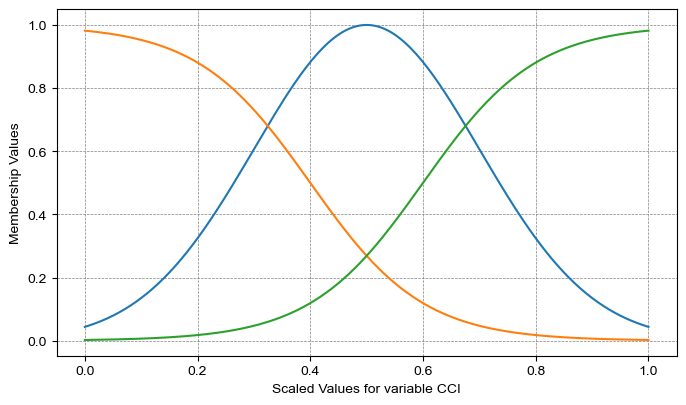

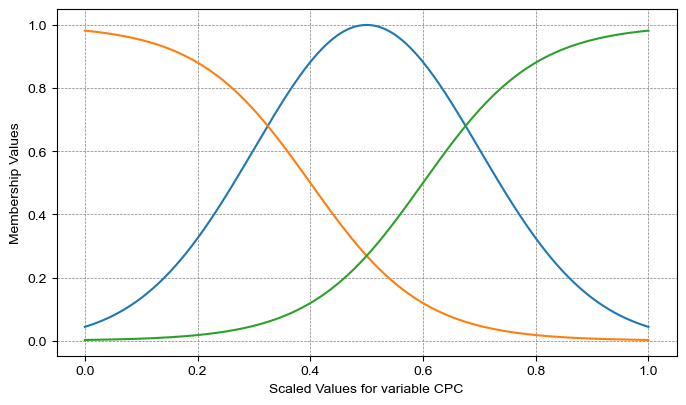

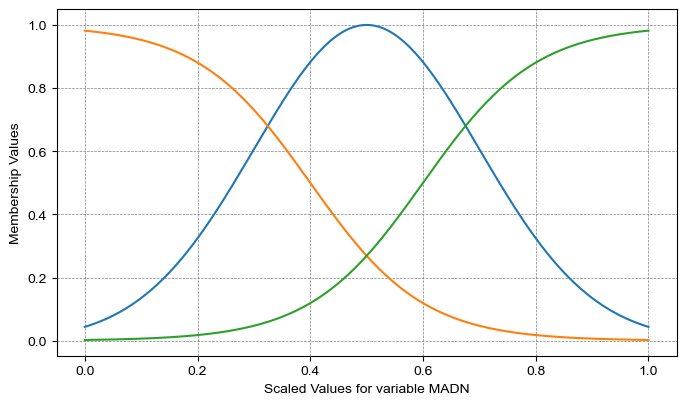

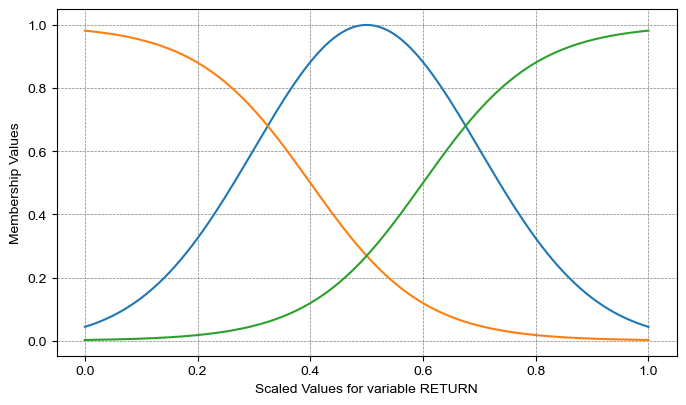

In [19]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)

# Ensure the order matches 'feature_columns' and the model's expectations
x = torch.stack([points_range, points_range, points_range, points_range, points_range], dim=1)  # Adjust the order if necessary

# Now call the plotting function, ensuring your model and the function are ready to use
experimental.plot_all_mfs(model, x)

In [20]:
# model.coeff
# Load the tensor from the file
# loaded_coefficients = torch.load('gianfis_coeff.pt')
# model.coefficients = loaded_coefficients

### Training for 2000 epochs, training size = 1216 cases
epoch    0: Loss=1.09253
epoch   10: Loss=0.95646
epoch   20: Loss=0.92623
epoch   30: Loss=0.91730
epoch   40: Loss=0.91383
epoch   50: Loss=0.91091
epoch   60: Loss=0.90778
epoch   70: Loss=0.90457
epoch   80: Loss=0.90161
epoch   90: Loss=0.89968
epoch  100: Loss=0.89680
epoch  110: Loss=0.89451
epoch  120: Loss=0.89237
epoch  130: Loss=0.88995
epoch  140: Loss=0.88744
epoch  150: Loss=0.88519
epoch  160: Loss=0.88315
epoch  170: Loss=0.88130
epoch  180: Loss=0.87962
epoch  190: Loss=0.87807
epoch  200: Loss=0.87664
epoch  210: Loss=0.87532
epoch  220: Loss=0.87409
epoch  230: Loss=0.87293
epoch  240: Loss=0.87185
epoch  250: Loss=0.87083
epoch  260: Loss=0.86986
epoch  270: Loss=0.86895
epoch  280: Loss=0.86807
epoch  290: Loss=0.86723
epoch  300: Loss=0.86641
epoch  310: Loss=0.86562
epoch  320: Loss=0.86485
epoch  330: Loss=0.86409
epoch  340: Loss=0.86335
epoch  350: Loss=0.86260
epoch  360: Loss=0.86187
epoch  370: Loss=0

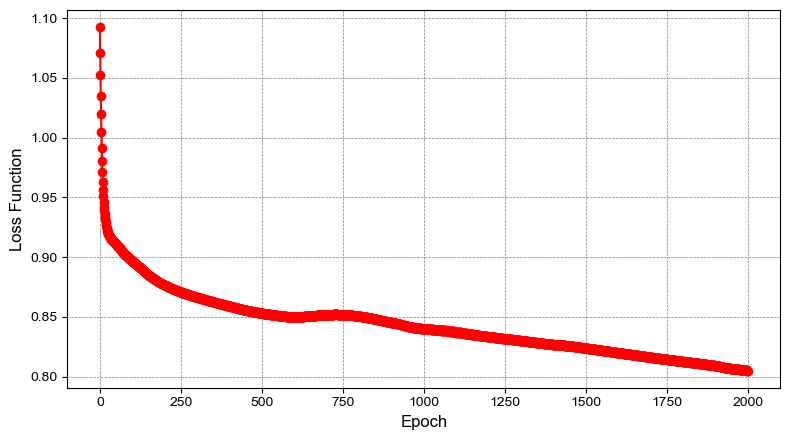

In [21]:
optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, data=train_loader, optimizer=optimizer, epochs=500, show_plots=True)

In [22]:
# Save consequent layer's parameters
# torch.save(model.coeff, 'gianfis_coeff.pt')

In [23]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

In [24]:
actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Accuracy: {accuracy:.2f}')

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)
print('Confusion Matrix:\n', train_conf_matrix)

# Classification Report
class_report = classification_report(actual_labels_train, predicted_labels_train)
print('Classification Report:\n', class_report)

Accuracy: 0.57
Confusion Matrix:
 [[287   3 235]
 [ 39  13  51]
 [189   3 396]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.56      0.55      0.55       525
           0       0.68      0.13      0.21       103
           1       0.58      0.67      0.62       588

    accuracy                           0.57      1216
   macro avg       0.61      0.45      0.46      1216
weighted avg       0.58      0.57      0.56      1216



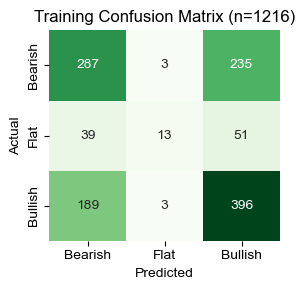

In [25]:
plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
plt.savefig('training_confusion_matrix.png', transparent=True)
plt.show()

In [26]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Accuracy: {accuracy:.2f}')

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)
print('Confusion Matrix:\n', test_conf_matrix)

# Classification Report
class_report = classification_report(actual_labels_test, predicted_labels_test)
print('Classification Report:\n', class_report)

Accuracy: 0.41
Confusion Matrix:
 [[13  0 45]
 [ 2  0 15]
 [15  3 43]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.43      0.22      0.30        58
           0       0.00      0.00      0.00        17
           1       0.42      0.70      0.52        61

    accuracy                           0.41       136
   macro avg       0.28      0.31      0.27       136
weighted avg       0.37      0.41      0.36       136



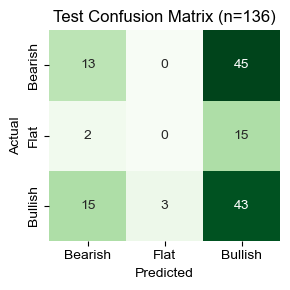

In [27]:
plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Test Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
plt.savefig('test_confusion_matrix.png', transparent=True)
plt.show()

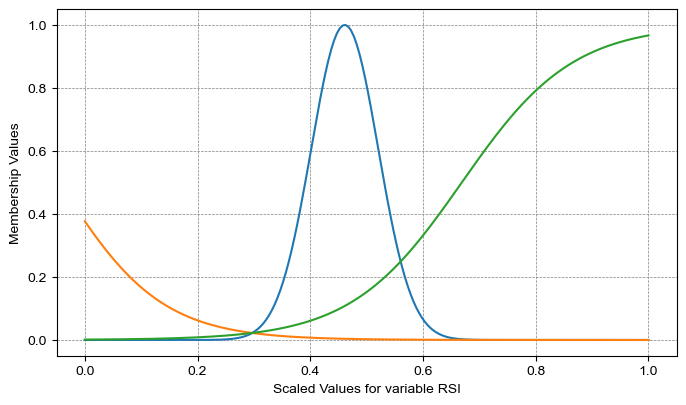

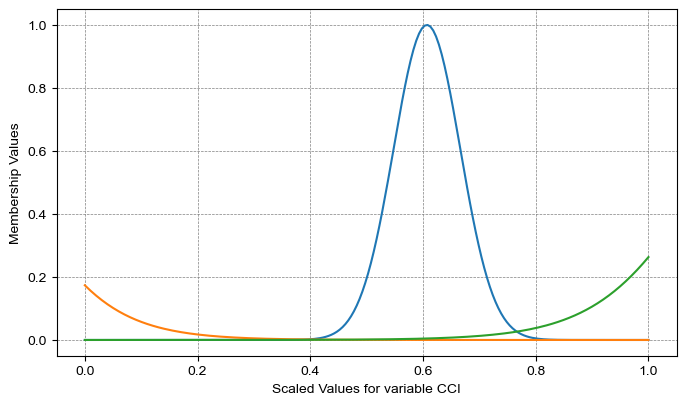

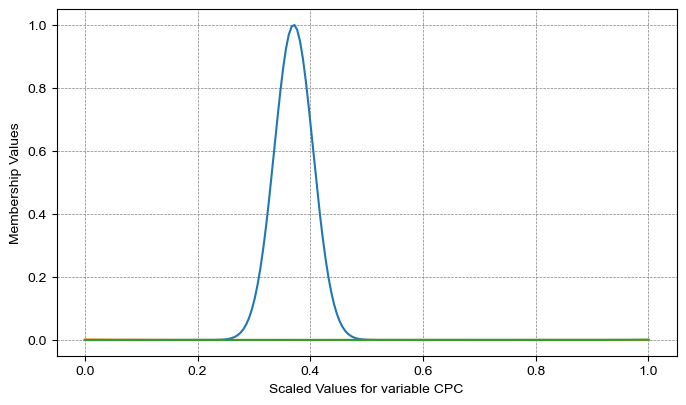

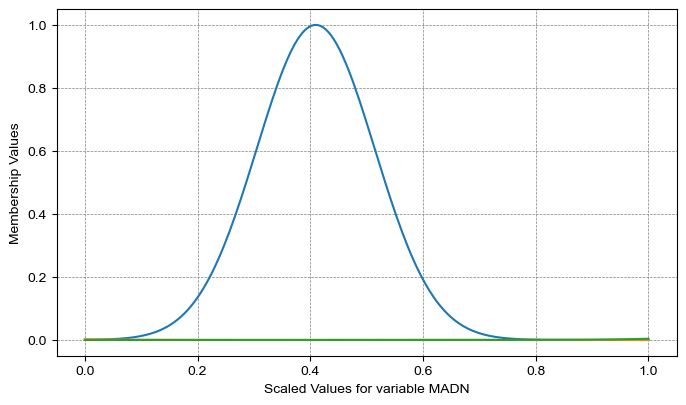

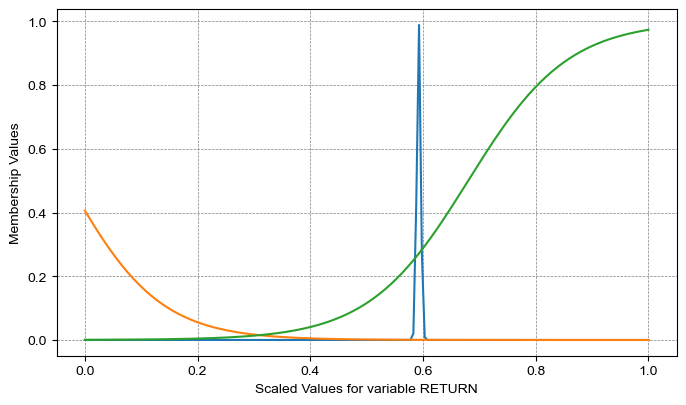

In [28]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)

# Ensure the order matches 'feature_columns' and the model's expectations
x = torch.stack([points_range, points_range, points_range, points_range, points_range], dim=1)  # Adjust the order if necessary

# Now call the plotting function, ensuring your model and the function are ready to use
experimental.plot_all_mfs(model, x)

Total return over the dataset: 75625912.0 %
Maximum Drawdown Duration 352 weeks


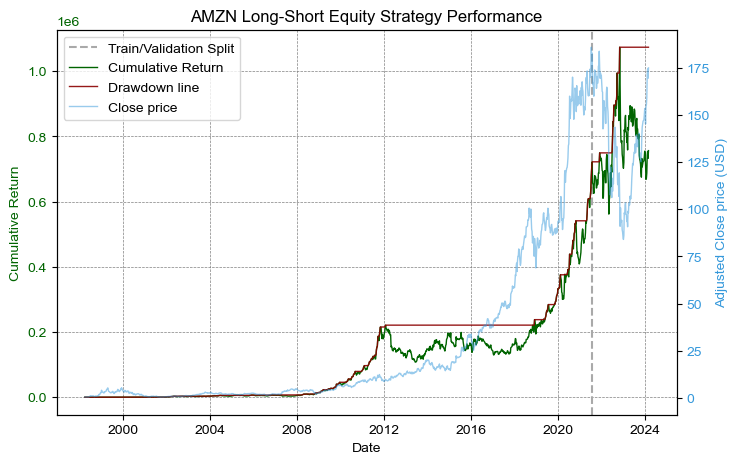

In [30]:
# Combine predictions into a single column
amzn['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

amzn=calculate_returns(amzn, 'Prediction')

max_drawdown_duration=calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

plot_return(amzn, 'AMZN', train_test_split=0.9, save_figure=False)

In [31]:
# Calculate cumulative return for a long-only strategy over the entire period
long_only_returns = (1 + amzn['Current_week_pct_change'] / 100).cumprod() - 1
print(f'WB total return: {round(long_only_returns.iloc[-1]*100, 1)} %')

# Calculate cumulative return for a long-only strategy over the validation set
validation_set = amzn.iloc[split_idx:]
long_only_returns_test = (1 + validation_set['Current_week_pct_change'] / 100).cumprod() - 1
print(f'WB return over validation set: {round(long_only_returns_test.iloc[-1]*100, 1)} %')

WB total return: 49308.5 %
WB return over validation set: -2.1 %


Total return over the dataset: 70560218.9 %
Training Set Maximum Drawdown: 352 weeks


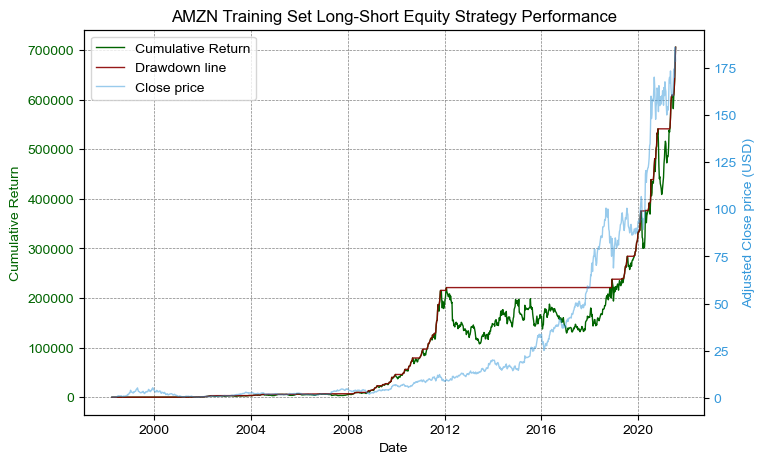

────────────────────────────────────────
Total return over the dataset: 4.7 %
Test Set Maximum Drawdown: 69 weeks


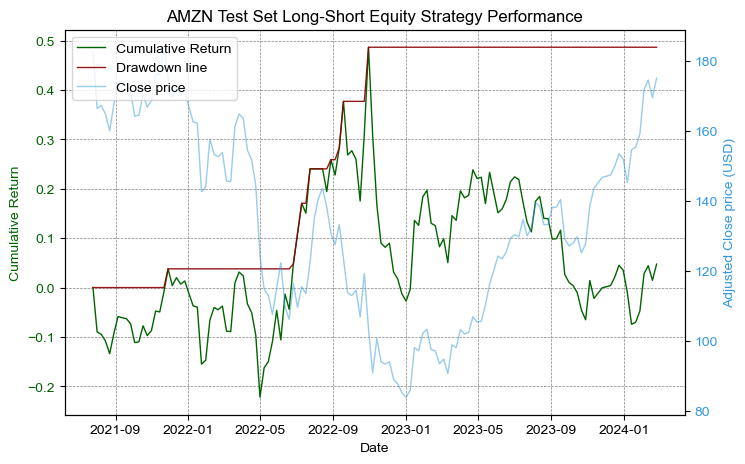

In [32]:
split_idx = int(len(amzn) * 0.9)

amzn_train_df = amzn.iloc[:split_idx].drop(columns=['Open', 'High', 'Low', 'RSI', 'CCI', 'EMA23', 'EMA53',
       'EMA23_EMA53_Difference_Normalized', 'CPC', 'Log_return']).copy()
amzn_test_df = amzn.iloc[split_idx:].drop(columns=['Open', 'High', 'Low', 'RSI', 'CCI', 'EMA23', 'EMA53',
       'EMA23_EMA53_Difference_Normalized', 'CPC', 'Log_return']).copy()

amzn_train_df = calculate_returns(amzn_train_df, 'Prediction')
max_drawdown_duration_train = calculate_max_drawdown_duration(amzn_train_df)
print(f'Training Set Maximum Drawdown: {max_drawdown_duration_train} weeks')
plot_return(amzn_train_df, 'AMZN Training Set')

print('─' * 40)

amzn_test_df = calculate_returns(amzn_test_df, 'Prediction')
max_drawdown_duration_test = calculate_max_drawdown_duration(amzn_test_df)
print(f'Test Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
plot_return(amzn_test_df, 'AMZN Test Set')

In [33]:
calculate_yearly_returns(amzn)

────────────────────────────────────────
Total return over the dataset: -42.9 %
Return in year 1998: -42.9 %
Maximum drawdown during year 1998: 14 weeks
────────────────────────────────────────
Total return over the dataset: 1185.5 %
Return in year 1999: 1185.5 %
Maximum drawdown during year 1999: 10 weeks
────────────────────────────────────────
Total return over the dataset: 650.1 %
Return in year 2000: 650.1 %
Maximum drawdown during year 2000: 16 weeks
────────────────────────────────────────
Total return over the dataset: 653.2 %
Return in year 2001: 653.2 %
Maximum drawdown during year 2001: 18 weeks
────────────────────────────────────────
Total return over the dataset: 310.8 %
Return in year 2002: 310.8 %
Maximum drawdown during year 2002: 33 weeks
────────────────────────────────────────
Total return over the dataset: 23.5 %
Return in year 2003: 23.5 %
Maximum drawdown during year 2003: 37 weeks
────────────────────────────────────────
Total return over the dataset: 14.0 %
Ret